# Ray Tracing

 Since we did not get the time in this course to do a project on Ray Tracing, I wrote this simple python ray tracer.

This is simple ray tracing implementation in Python, designed to render a scene with multiple spheres, each exhibiting reflective properties and casting shadows. It can handle, reflections, refractions, shadows, different colors, lighting, and camera changes(focous).

In [71]:
import numpy as np

**Ray Class:** Represents a ray in the scene, defined by its origin and direction.

In [72]:
class Ray:
    def __init__(self, origin, direction):
        self.origin = np.array(origin)
        self.direction = np.array(direction) / np.linalg.norm(direction)

**Camera Class:**

**Computing Camera Basis Vectors:**
Upon initialization, the camera's basis vectors (u, v, w) are computed. These vectors are essential for determining the direction of the rays that emanate from the camera.
The w vector is calculated as the difference between the position and look_at vectors, representing the camera's viewing direction.
The u vector is the cross product of the up vector and w, representing the camera's horizontal axis.
The v vector, representing the camera's vertical axis, is obtained by crossing w and u.

**Ray Generation (get_ray Method)**:
This method generates a ray for each pixel of the image. The direction of each ray is calculated based on the camera's field of view and the pixel's position in the image plane.

For depth of field simulation, if the aperture size is greater than zero, the origin of the ray is jittered within a circular aperture, and the ray is directed towards a point in the scene that lies at the camera's focal length. This mimics the behavior of a real camera lens and creates the blur effect associated with depth of field.

**Handling Aspect Ratio:**
Aspect ratio (width divided by height of the image) is considered when calculating the ray direction, ensuring that the rendered image has correct proportions without stretching or squashing.

In [123]:
class Camera:
    def __init__(self, position, look_at, up, fov, aperture_size, focal_length):
        self.position = np.array(position, dtype=np.float64)
        self.look_at = np.array(look_at, dtype=np.float64)
        self.up = np.array(up, dtype=np.float64)
        self.fov = fov
        self.aperture_size = aperture_size
        self.focal_length = focal_length

        # Compute camera basis vectors
        self.w = self.position - self.look_at
        self.w /= np.linalg.norm(self.w)
        self.u = np.cross(self.up, self.w)
        self.u /= np.linalg.norm(self.u)
        self.v = np.cross(self.w, self.u)
        self.v /= np.linalg.norm(self.v)

    def get_ray(self, x, y, width, height):
        # Calculate ray direction for given pixel
        aspect_ratio = width / height
        alpha = np.tan(np.radians(self.fov / 2)) * aspect_ratio
        beta = np.tan(np.radians(self.fov / 2))
        direction = -self.w + alpha * x * self.u + beta * y * self.v
        direction = direction / np.linalg.norm(direction)

        # Simulate depth of field
        if self.aperture_size > 0:
            p = self.aperture_size * (np.random.rand(2) - 0.5)
            origin = self.position + p[0] * self.u + p[1] * self.v
            focus_point = self.position + direction * self.focal_length
            direction = focus_point - origin
            direction /= np.linalg.norm(direction)
        else:
            origin = self.position

        return Ray(origin, direction)

**Sphere Class**

**Initialization:** The Sphere class represents a spherical object in the scene. Each sphere is defined by its center coordinates, radius, color, and reflectivity. The reflectivity indicates how reflective the surface of the sphere is, with 0 being completely non-reflective and 1 being fully reflective like a mirror.

**Intersection Method:** This method calculates if and where a ray intersects with the sphere. This is crucial for determining how light interacts with the sphere.

**Normal Calculation:** The class can compute the normal (a perpendicular vector) at any point on the sphere's surface, which is essential for lighting and reflection calculations.

In [117]:
class Sphere:
    def __init__(self, center, radius, color, reflectivity=0.0, transparency=0.0, index_of_refraction=1.0):
        self.center = np.array(center)
        self.radius = radius
        self.color = color
        self.reflectivity = reflectivity
        self.transparency = transparency
        self.index_of_refraction = index_of_refraction

    def intersect(self, ray):
        oc = ray.origin - self.center
        a = np.dot(ray.direction, ray.direction)
        b = 2.0 * np.dot(oc, ray.direction)
        c = np.dot(oc, oc) - self.radius * self.radius
        discriminant = b * b - 4 * a * c

        if discriminant < 0:
            return None
        else:
            t = (-b - np.sqrt(discriminant)) / (2.0 * a)
            return t if t > 0 else None

    def normal_at(self, point):
        return (point - self.center) / self.radius

    # Material properties
    def material(self):
        return {
            'diffuse': self.color,
            'specular': np.array([1, 1, 1]), # assuming white specular highlights
            'shininess': 30  # Shininess coefficient
        }

**Ray Tracing**

**Ray Class:** Represents a ray in the scene, defined by its origin and direction.
Trace Ray Function: This function is the core of ray tracing. It takes a ray and determines its interactions with objects in the scene. For each ray, it finds the closest object that the ray intersects with, calculates the intersection point, and determines the color at that point based on lighting and material properties.

**Recursive Reflections:** For reflective surfaces, the function generates a new reflected ray and recursively traces it. This is used to simulate reflections, with a limit (max_depth) on recursion depth to prevent infinite loops.

**Shadow Calculation:** The function checks whether a point on an object is in shadow by casting a ray towards the light source and checking if it intersects with any other object.

In [111]:
def trace_ray(ray, objects, light, depth=0, max_depth=3):
    if depth > max_depth:
        return np.array([0, 0, 0])  # Too deep, return black

    closest_t = float('inf')
    closest_object = None
    for obj in objects:
        t = obj.intersect(ray)
        if t and t < closest_t:
            closest_t = t
            closest_object = obj

    if closest_object:
        hit_point = ray.origin + closest_t * ray.direction
        normal = closest_object.normal_at(hit_point)
        material = closest_object.material()
        color = blinn_phong_lighting(ray, hit_point, normal, light, material, objects, closest_object)

        # Reflectivity
        if closest_object.reflectivity > 0:
            reflect_dir = ray.direction - 2 * np.dot(ray.direction, normal) * normal
            reflect_ray = Ray(hit_point + 0.001 * reflect_dir, reflect_dir)
            reflect_color = trace_ray(reflect_ray, objects, light, depth + 1, max_depth)
            color = (1 - closest_object.reflectivity) * color + closest_object.reflectivity * reflect_color

        if closest_object.transparency > 0:
            eta = closest_object.index_of_refraction
            if np.dot(ray.direction, normal) < 0:  # Ray entering the object
                eta = 1.0 / eta
            refracted_dir = refract(ray.direction, normal, eta)
            if refracted_dir is not None:
                refracted_ray = Ray(hit_point - 0.001 * refracted_dir, refracted_dir)
                refracted_color = trace_ray(refracted_ray, objects, light, depth + 1, max_depth)
                color = (1 - closest_object.transparency) * color + closest_object.transparency * refracted_color

        return color
    else:
        return np.array([1, 1, 1])  # White background color


In [ ]:
def refract(in_direction, normal, eta):
    cos_theta = -np.dot(normal, in_direction)
    k = 1 - eta * eta * (1 - cos_theta * cos_theta)
    if k < 0:  # Total internal reflection
        return None
    else:
        return eta * in_direction + (eta * cos_theta - np.sqrt(k)) * normal

**Light and Shading**

**Blinn-Phong Lighting Model:** Used for calculating the illumination of each point on the objects' surfaces. It considers the diffuse, specular , and ambient components.

**Shadow Checking:** Determines if a point is in shadow by casting a shadow ray towards the light source. If any object blocks this ray, the point is considered to be in shadow and is rendered darker.

In [112]:
def blinn_phong_lighting(ray, hit_point, normal, light, material, objects, hit_object):
    if is_in_shadow(hit_point, light, objects, hit_object):
        return np.array([0, 0, 0])  #In shadow, return dark color

    # Calculate diffuse lighting
    light_dir = (light['position'] - hit_point)
    light_dir = light_dir / np.linalg.norm(light_dir)
    diffuse = light['color'] * material['diffuse'] * max(np.dot(normal, light_dir), 0)

    # Calculate specular lighting
    view_dir = -ray.direction
    half_dir = (light_dir + view_dir) / np.linalg.norm(light_dir + view_dir)
    specular = light['color'] * material['specular'] * (max(np.dot(normal, half_dir), 0) ** material['shininess'])

    # Ambient lighting can be added here as well

    return diffuse + specular

In [113]:
def is_in_shadow(hit_point, light, objects, ignore_object):
    shadow_ray_direction = light['position'] - hit_point
    shadow_ray = Ray(hit_point + 0.001 * shadow_ray_direction, shadow_ray_direction)  # Small offset to avoid self-shadowing glitch

    for obj in objects:
        if obj is not ignore_object:
            if obj.intersect(shadow_ray):
                return True
    return False

**Scene Setup and Rendering**

**Multiple Spheres:** The scene consists of several spheres, each with different properties (color, size, position, and reflectivity).
Light Source: Defined by its position and color. It's the primary source of illumination in the scene.

**Rendering Loop:** The render function iterates over each pixel of the image, creates a ray from the camera through the pixel, and uses the trace_ray function to determine the pixel's color based on the ray's interactions in the scene.

**Image Display:** The rendered image, which is a 2D array of pixel colors, is displayed using matplotlib.

In [127]:
def render(scene_objects, light, camera, width, height, samples_per_pixel=1):
    aspect_ratio = width / height
    image = np.zeros((height, width, 3), dtype=np.float64)

    for j in range(height):
        for i in range(width):
            color = np.array([0, 0, 0], dtype=np.float64)
            for s in range(samples_per_pixel):  # Antialiasing samples
                x = (2 * (i + np.random.rand()) / width - 1) * aspect_ratio
                y = 1 - 2 * (j + np.random.rand()) / height
                ray = camera.get_ray(x, y, width, height)
                color += trace_ray(ray, scene_objects, light)
            image[j, i] = np.clip(color / samples_per_pixel, 0, 1)
    return image

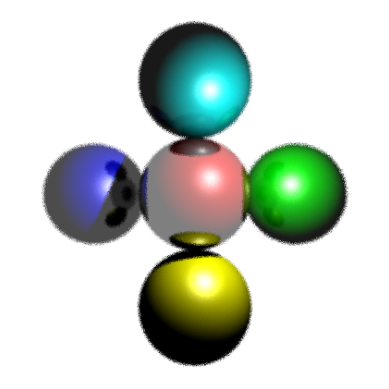

In [137]:
# Create multiple spheres
spheres = [
    Sphere([0, 0, -5], 1, np.array([1, 0, 0]),reflectivity=0.5, transparency=0.5, index_of_refraction=1.5),   # Red sphere
    Sphere([2, 0, -6], 1, np.array([0, 1, 0]),reflectivity=0.1),   # Green sphere
    Sphere([-2, 0, -6], 1, np.array([0, 0, 1]),reflectivity=0.3, transparency=0.5, index_of_refraction=1.5),  # Blue sphere
    Sphere([0, -2, -5], 1, np.array([1, 1, 0]),reflectivity=0.0),  # Yellow sphere
    Sphere([0, 2, -5], 1, np.array([0, 1, 1]),reflectivity=0.1)    # Cyan sphere
]


# Define the light source
light = {
    'position': np.array([1, 1, -3]),
    'color': np.array([1, 1, 1])  # White light
}

camera = Camera(
    position=[0, 0, 3],
    look_at=[0, 0, -1],
    up=[0, 1, 0],
    fov=45,
    aperture_size=0.1,  # Change the aperture size for more or less blur
    focal_length=5     # Adjust the focal length to focus on different parts of the scene
)

# Render the scene with depth of field
image = render(spheres, light, camera, 400, 400, samples_per_pixel=10)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


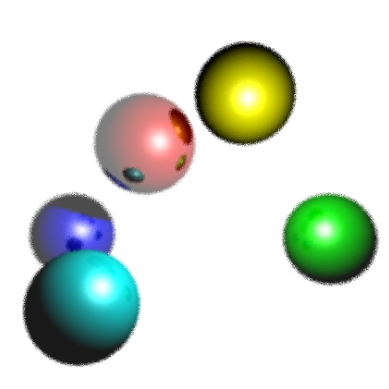

In [136]:
# Create multiple spheres
# Updated positions of the spheres
spheres = [
    Sphere([-1, 1, -6], 1, np.array([1, 0, 0]), reflectivity=0.5, transparency=0.5, index_of_refraction=1.5),   # Red sphere, moved to the left and back
    Sphere([3, -1, -7], 1, np.array([0, 1, 0]), reflectivity=0.1),   # Green sphere, moved to the right and further back
    Sphere([-3, -1, -8], 1, np.array([0, 0, 1]), reflectivity=0.3, transparency=0.5, index_of_refraction=1.5),  # Blue sphere, moved to the left and even further back
    Sphere([1, 2, -6], 1, np.array([1, 1, 0]), reflectivity=0.0),    # Yellow sphere, moved up and back
    Sphere([-2, -2, -5], 1, np.array([0, 1, 1]), reflectivity=0.1)   # Cyan sphere, moved down and slightly back
]

# Define the light source
light = {
    'position': np.array([1, 1, -3]),
    'color': np.array([1, 1, 1])  # White light
}

camera = Camera(
    position=[0, 0, 3],
    look_at=[0, 0, -1],
    up=[0, 1, 0],
    fov=45,
    aperture_size=0.1,  # Change the aperture size for more or less blur
    focal_length=5     # Adjust the focal length to focus on different parts of the scene
)

# Render the scene with depth of field
image = render(spheres, light, camera, 400, 400, samples_per_pixel=10)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()


# Implicitron

I did not write all this code. I just modified some prexisitng code from facebook to generate a synethetic NeRF of our SMPL Human mesh that we had been playing with in Project 2, with one of the textures I had made with your face!

In [138]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

## 0. Install and import modules


In [2]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=78d6f68040857fb07e0eacf777d888202f3bc5b050718526f8ce080e946caede
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=6c5575452f54ed1d3bd8170990e50ed302dc1e228baa42a621f44aba21216a41
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 124.3 MB/s eta 0:00:00


Ensure omegaconf and visdom are installed. If not, run this cell. (It should not be necessary to restart the runtime.)

In [3]:
!pip install omegaconf visdom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 16.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=95b9e26820cb60b3a73cb766ffe1890277fb097aebc16a0583fad8721768231e
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=57f659f0c65e85511268e10212d32e590f17e97fb9cc38c42c51c108d3f5ffc3
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
Successfully built antlr4-python3-runtime visdom


In [43]:
import logging
from typing import Tuple

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from IPython.display import HTML
from omegaconf import OmegaConf
from PIL import Image
from pytorch3d.implicitron.dataset.dataset_base import FrameData
from pytorch3d.implicitron.dataset.rendered_mesh_dataset_map_provider import RenderedMeshDatasetMapProvider
from pytorch3d.implicitron.models.generic_model import GenericModel
from pytorch3d.implicitron.models.implicit_function.base import ImplicitFunctionBase, ImplicitronRayBundle
from pytorch3d.implicitron.models.renderer.base import EvaluationMode
from pytorch3d.implicitron.tools.config import get_default_args, registry, remove_unused_components
from pytorch3d.renderer.implicit.renderer import VolumeSampler
from pytorch3d.structures import Volumes
from pytorch3d.vis.plotly_vis import plot_batch_individually, plot_scene

In [44]:
output_resolution = 160

In [45]:
torch.set_printoptions(sci_mode=False)

## 1. Load renders of a mesh (the cow mesh) as a dataset

A dataset's train, val and test parts in Implicitron are represented as a `dataset_map`, and provided by an implementation of `DatasetMapProvider`.
`RenderedMeshDatasetMapProvider` is one which generates a single-scene dataset with only a train component by taking a mesh and rendering it.
We use it with the cow mesh.

In [46]:
smpl_provider = RenderedMeshDatasetMapProvider(
    data_file="data/smpl_uv/smpl_uv.obj",
    use_point_light=False,
    resolution=output_resolution,
)

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/utils.py:58: UserWarning:

Faces have invalid indices



In [47]:
dataset_map = smpl_provider.get_dataset_map()
tr_cameras = [training_frame.camera for training_frame in dataset_map.train]

In [48]:
# The cameras are all in the XZ plane, in a circle about 2.7 from the origin
centers = torch.cat([i.get_camera_center() for i in tr_cameras])
print(centers.min(0).values)
print(centers.max(0).values)

tensor([-2.6978,  0.0000, -2.6912])
tensor([2.6978, 0.0000, 2.7000])


In [49]:
# visualization of the cameras
plot = plot_scene({"k": {i: camera for i, camera in enumerate(tr_cameras)}}, camera_scale=0.25)
plot.layout.scene.aspectmode = "data"
plot

## 2. Custom implicit function 🧊

At the core of neural rendering methods are functions of spatial coordinates called implicit functions, which are used in some kind of rendering process.
(Often those functions can additionally take other data as well, such as view direction.)
A common rendering process is ray marching over densities and colors provided by an implicit function.
In our case, taking samples from a 3D volume grid is a very simple function of spatial coordinates.

Here we define our own implicit function, which uses PyTorch3D's existing functionality for sampling from a volume grid.
We do this by subclassing `ImplicitFunctionBase`.
We need to register our subclass with a special decorator.
We use Python's dataclass annotations for configuring the module.

In [50]:
@registry.register
class MyVolumes(ImplicitFunctionBase, torch.nn.Module):
    grid_resolution: int = 50  # common HWD of volumes, the number of voxels in each direction
    extent: float = 1.0  # In world coordinates, the volume occupies is [-extent, extent] along each axis

    def __post_init__(self):
        # We have to call this explicitly if there are other base classes like Module
        super().__init__()

        # We define parameters like other torch.nn.Module objects.
        # In this case, both our parameter tensors are trainable; they govern the contents of the volume grid.
        density = torch.full((self.grid_resolution, self.grid_resolution, self.grid_resolution), -2.0)
        self.density = torch.nn.Parameter(density)
        color = torch.full((3, self.grid_resolution, self.grid_resolution, self.grid_resolution), 0.0)
        self.color = torch.nn.Parameter(color)
        self.density_activation = torch.nn.Softplus()

    def forward(
        self,
        ray_bundle: ImplicitronRayBundle,
        fun_viewpool=None,
        global_code=None,
    ):
        densities = self.density_activation(self.density[None, None])
        voxel_size = 2.0 * float(self.extent) / self.grid_resolution
        features = self.color.sigmoid()[None]

        # Like other PyTorch3D structures, the actual Volumes object should only exist as long
        # as one iteration of training. It is local to this function.

        volume = Volumes(densities=densities, features=features, voxel_size=voxel_size)
        sampler = VolumeSampler(volumes=volume)
        densities, features = sampler(ray_bundle)

        # When an implicit function is used for raymarching, i.e. for MultiPassEmissionAbsorptionRenderer,
        # it must return (densities, features, an auxiliary tuple)
        return densities, features, {}


## 3. Construct the model object.

The main model object in PyTorch3D is `GenericModel`, which has pluggable components for the major steps, including the renderer and the implicit function(s).
There are two ways to construct it which are equivalent here.

In [51]:
CONSTRUCT_MODEL_FROM_CONFIG = True
if CONSTRUCT_MODEL_FROM_CONFIG:
    # Via a DictConfig - this is how our training loop with hydra works
    cfg = get_default_args(GenericModel)
    cfg.implicit_function_class_type = "MyVolumes"
    cfg.render_image_height=output_resolution
    cfg.render_image_width=output_resolution
    cfg.loss_weights={"loss_rgb_huber": 1.0}
    cfg.tqdm_trigger_threshold=19000
    cfg.raysampler_AdaptiveRaySampler_args.scene_extent= 4.0
    gm = GenericModel(**cfg)
else:
    # constructing GenericModel directly
    gm = GenericModel(
        implicit_function_class_type="MyVolumes",
        render_image_height=output_resolution,
        render_image_width=output_resolution,
        loss_weights={"loss_rgb_huber": 1.0},
        tqdm_trigger_threshold=19000,
        raysampler_AdaptiveRaySampler_args = {"scene_extent": 4.0}
    )

    # In this case we can get the equivalent DictConfig cfg object to the way gm is configured as follows
    cfg = OmegaConf.structured(gm)


 The default renderer is an emission-absorbtion raymarcher. We keep that default.

In [52]:
# We can display the configuration in use as follows.
remove_unused_components(cfg)
yaml = OmegaConf.to_yaml(cfg, sort_keys=False)
%page -r yaml

In [53]:
device = torch.device("cuda:0")
gm.to(device)
assert next(gm.parameters()).is_cuda

## 4. train the model

In [54]:
train_data_collated = [FrameData.collate([frame.to(device)]) for frame in dataset_map.train]

In [55]:
gm.train()
optimizer = torch.optim.Adam(gm.parameters(), lr=0.1)

In [56]:
iterator = tqdm.tqdm(range(2000))
for n_batch in iterator:
    optimizer.zero_grad()

    frame = train_data_collated[n_batch % len(dataset_map.train)]
    out = gm(**frame, evaluation_mode=EvaluationMode.TRAINING)
    out["objective"].backward()
    if n_batch % 100 == 0:
        iterator.set_postfix_str(f"loss: {float(out['objective']):.5f}")
    optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/pytorch3d/implicitron/models/utils.py:72: UserWarning:

Thresholding masks!

/usr/local/lib/python3.10/dist-packages/pytorch3d/implicitron/models/utils.py:77: UserWarning:

Masking images!

100%|██████████| 2000/2000 [00:28<00:00, 70.39it/s, loss: 0.00462]


## 5. Evaluate the module

We generate complete images from all the viewpoints to see how they look.

In [57]:
def to_numpy_image(image):
    # Takes an image of shape (C, H, W) in [0,1], where C=3 or 1
    # to a numpy uint image of shape (H, W, 3)
    return (image * 255).to(torch.uint8).permute(1, 2, 0).detach().cpu().expand(-1, -1, 3).numpy()
def resize_image(image):
    # Takes images of shape (B, C, H, W) to (B, C, output_resolution, output_resolution)
    return torch.nn.functional.interpolate(image, size=(output_resolution, output_resolution))

gm.eval()
images = []
expected = []
masks = []
masks_expected = []
for frame in tqdm.tqdm(train_data_collated):
    with torch.no_grad():
        out = gm(**frame, evaluation_mode=EvaluationMode.EVALUATION)

    image_rgb = to_numpy_image(out["images_render"][0])
    mask = to_numpy_image(out["masks_render"][0])
    expd = to_numpy_image(resize_image(frame.image_rgb)[0])
    mask_expected = to_numpy_image(resize_image(frame.fg_probability)[0])

    images.append(image_rgb)
    masks.append(mask)
    expected.append(expd)
    masks_expected.append(mask_expected)

100%|██████████| 40/40 [00:56<00:00,  1.40s/it]


We draw a grid showing predicted image and expected image, followed by predicted mask and expected mask, from each viewpoint.
This is a grid of four rows of images, wrapped in to several large rows, i.e..
<small><center>
```
┌────────┬────────┐           ┌────────┐
│pred    │pred    │           │pred    │
│image   │image   │           │image   │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│image   │image   │  ...      │image   │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│pred    │pred    │           │pred    │
│mask    │mask    │           │mask    │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│mask    │mask    │           │mask    │
│1       │2       │           │n       │
├────────┼────────┤           ├────────┤
│pred    │pred    │           │pred    │
│image   │image   │           │image   │
│n+1     │n+1     │           │2n      │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│image   │image   │  ...      │image   │
│n+1     │n+2     │           │2n      │
├────────┼────────┤           ├────────┤
│pred    │pred    │           │pred    │
│mask    │mask    │           │mask    │
│n+1     │n+2     │           │2n      │
├────────┼────────┤           ├────────┤
│expected│expected│           │expected│
│mask    │mask    │           │mask    │
│n+1     │n+2     │           │2n      │
└────────┴────────┘           └────────┘
           ...
```
</center></small>

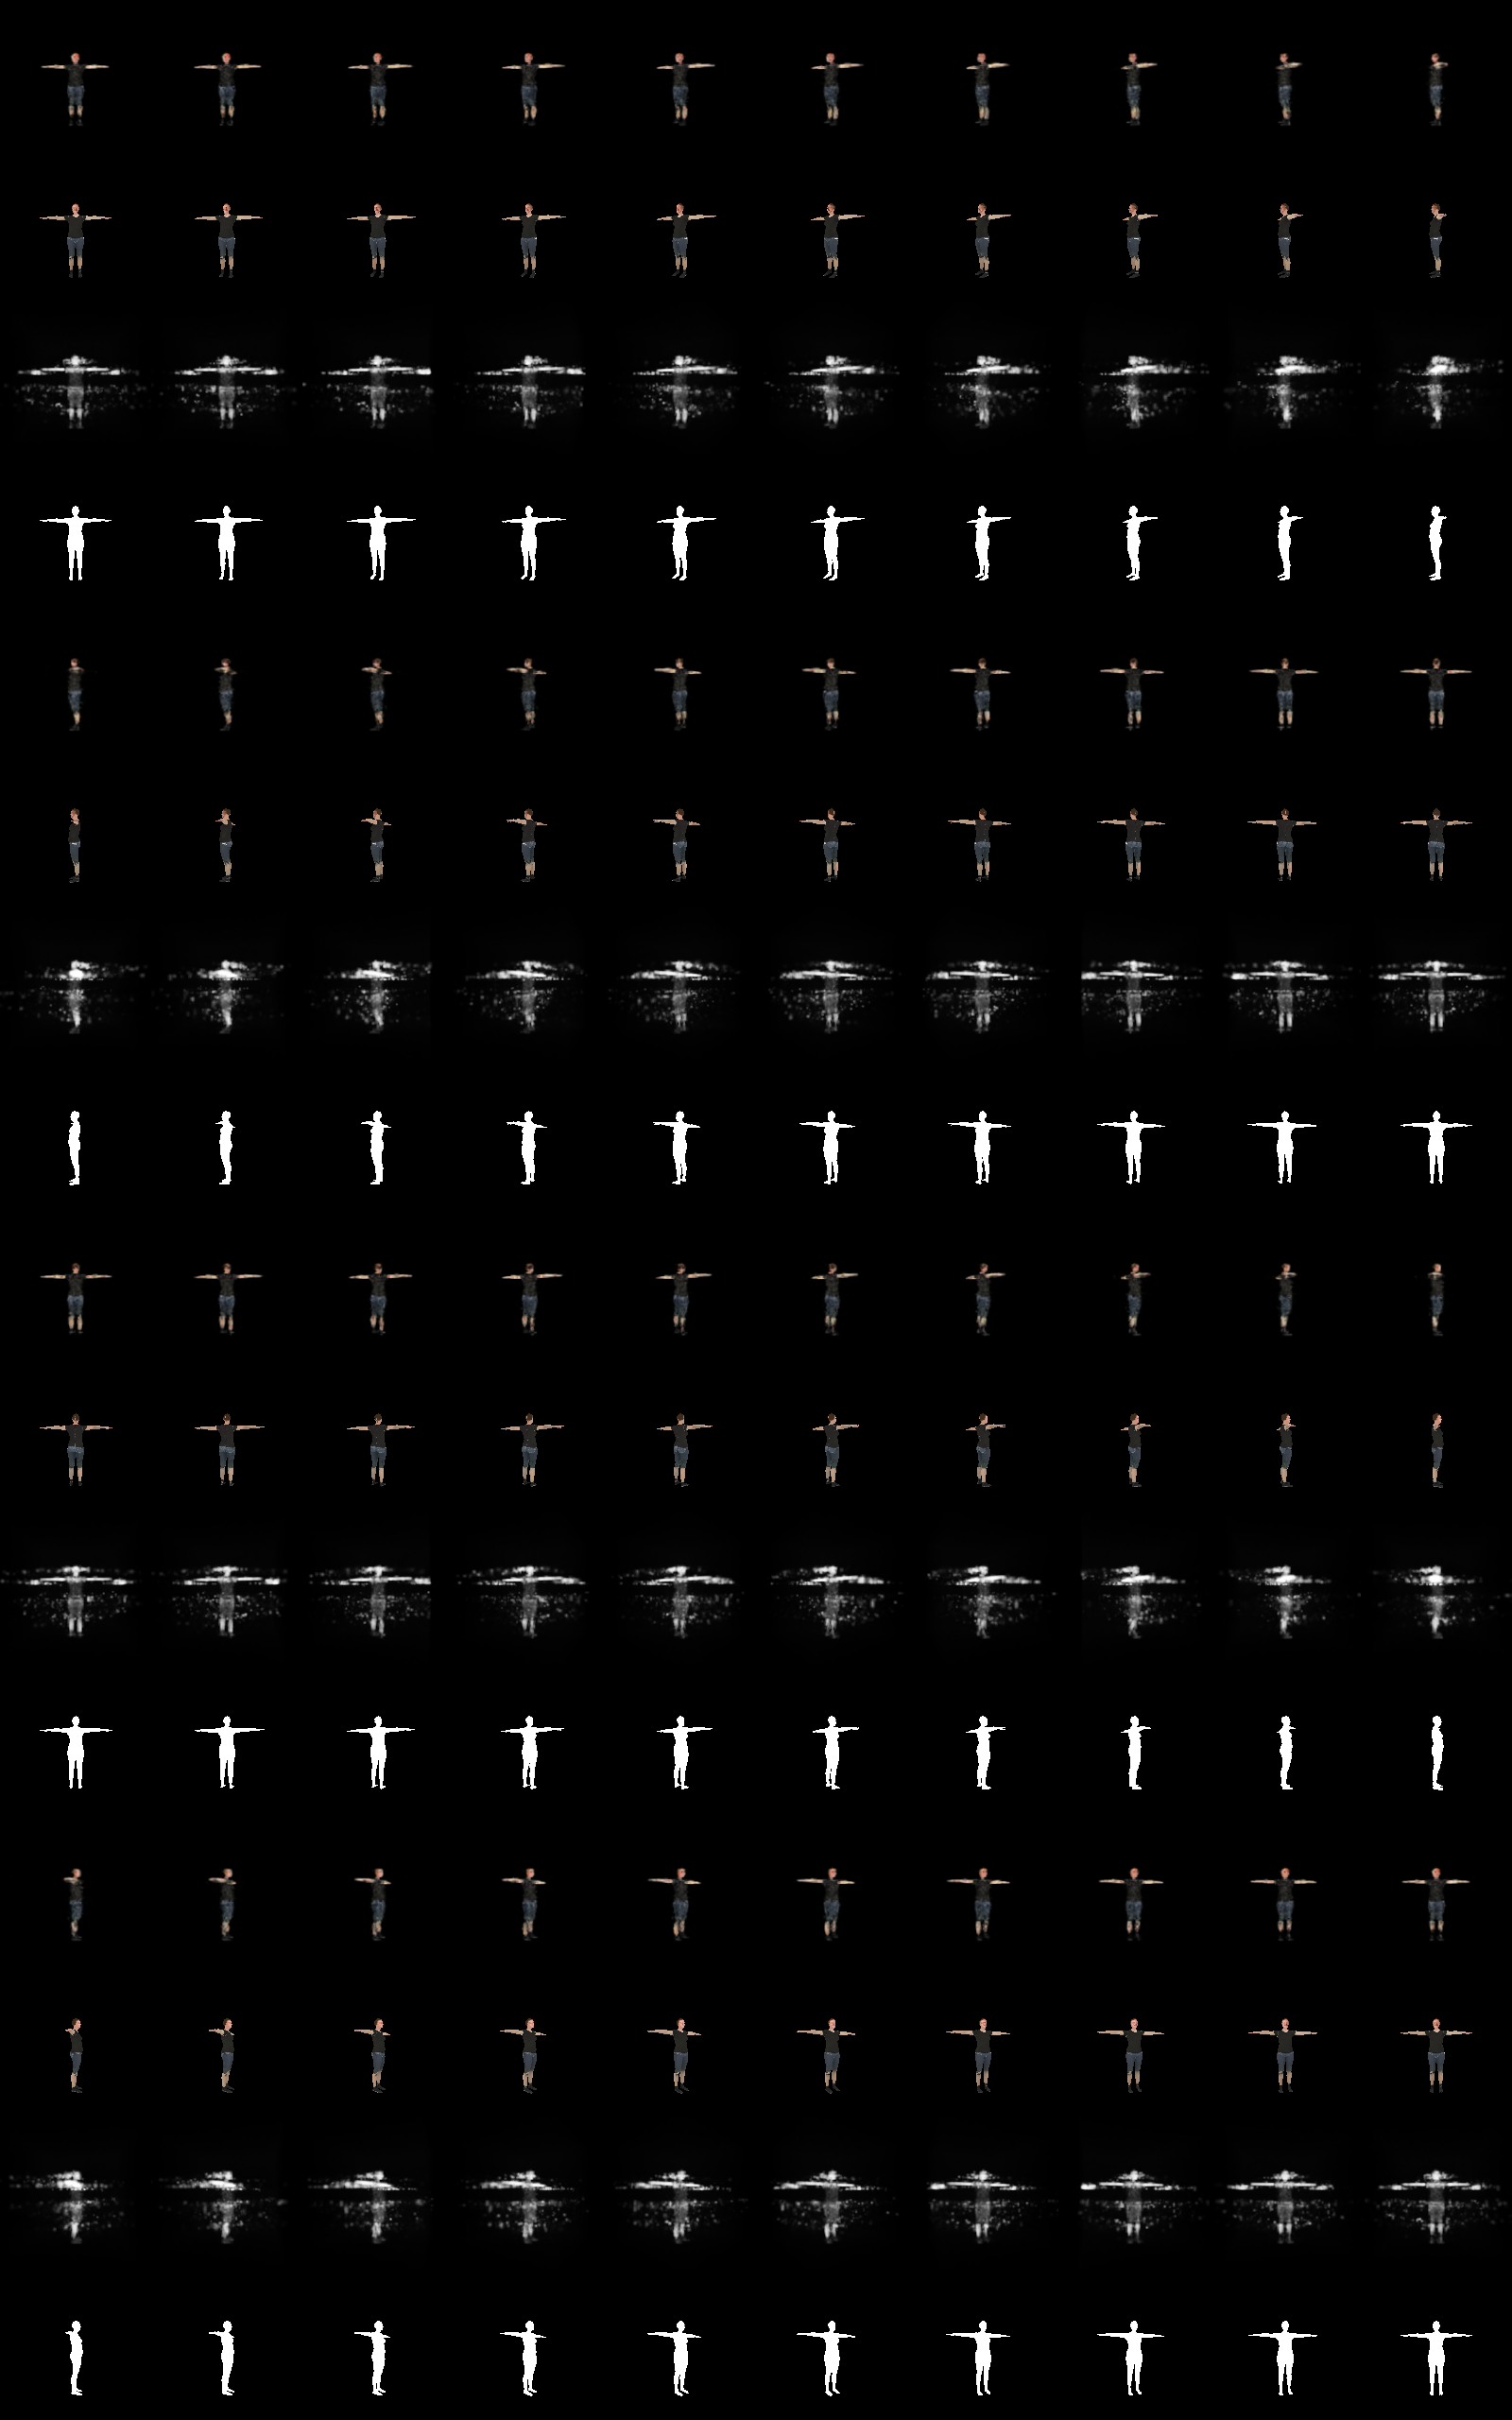

In [58]:
images_to_display = [images.copy(), expected.copy(), masks.copy(), masks_expected.copy()]
n_rows = 4
n_images = len(images)
blank_image = images[0] * 0
n_per_row = 1+(n_images-1)//n_rows
for _ in range(n_per_row*n_rows - n_images):
    for group in images_to_display:
        group.append(blank_image)

images_to_display_listed = [[[i] for i in j] for j in images_to_display]
split = []
for row in range(n_rows):
    for group in images_to_display_listed:
        split.append(group[row*n_per_row:(row+1)*n_per_row])

Image.fromarray(np.block(split))


In [59]:
# Print the maximum channel intensity in the first image.
print(images[1].max()/255)

0.9137254901960784


In [60]:
plt.ioff()
fig, ax = plt.subplots(figsize=(3,3))

ax.grid(None)
ims = [[ax.imshow(im, animated=True)] for im in images]
ani = animation.ArtistAnimation(fig, ims, interval=80, blit=True)
ani_html = ani.to_jshtml()


In [61]:
HTML(ani_html)

In [24]:
# If you want to see the output of the model with the volume forced to opaque white, run this and re-evaluate
# with torch.no_grad():
#      gm._implicit_functions[0]._fn.density.fill_(9.0)
#      gm._implicit_functions[0]._fn.color.fill_(9.0)


# Tiny NeRF

This is another demo I found and played with in colab of NeRFs leveraging pytorch to train a nerf which I experimented with.

In [ ]:
# Import all the good stuff
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

There's plenty of differences in function signatures (and in functionality) b/w PyTorch and TensorFlow. Here's a few modules that help bridge the gap (for this particular impl).

In [ ]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

In [ ]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

We assume that a _near_ and a _far_ clipping distance are provided that delineate the volume of interest. Each ray is evaluated only within these bounds. We randomly sample points along each ray, while trying to ensure most parts of the ray's trajectory are spanned.

In [ ]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # TESTED
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]
  # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
  return query_points, depth_values

#### Volumetric rendering

> **NOTE**: This volumetric rendering module (like the authors' tiny_nerf [Colab notebook](https://colab.research.google.com/github/bmild/nerf/blob/master/tiny_nerf.ipynb) does not implement 5D input (which includes view directions, in addition to X, Y, Z coordinates). It also does not implement the hierarchical sampling procedure. For those implementations, refer to the other complete examples in the repo.

In [ ]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

Another interesting tweak used in NeRF is "positional encoding", which postulates the use of a mapping to higher dimensional space (using a basis set of high-frequency functions). This greatly enhances the model's capability to capture high-frequency variations.

In [ ]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).
    log_sampling (optional, bool): Sample logarithmically in frequency space, as
        opposed to linearly (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # TESTED
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = None
  if log_sampling:
      frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
  else:
      frequency_bands = torch.linspace(
          2.0 ** 0.0,
          2.0 ** (num_encoding_functions - 1),
          num_encoding_functions,
          dtype=tensor.dtype,
          device=tensor.device,
      )

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## NeRF: Network architecture

In [ ]:
class VeryTinyNerfModel(torch.nn.Module):
  r"""Define a "very tiny" NeRF model comprising three fully connected layers.
  """
  def __init__(self, filter_size=128, num_encoding_functions=6):
    super(VeryTinyNerfModel, self).__init__()
    # Input layer (default: 39 -> 128)
    self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
    # Layer 2 (default: 128 -> 128)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    # Layer 3 (default: 128 -> 4)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    # Short hand for torch.nn.functional.relu
    self.relu = torch.nn.functional.relu

  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

## Dataloading utils

In [ ]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [ ]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-06-06 16:56:58--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-06-06 16:56:59--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  6.52MB/s    in 1.9s    

2023-06-06 16:57:01 (6.52 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



## Determine device to run on (GPU vs CPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [ ]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

#### Display the image used for testing

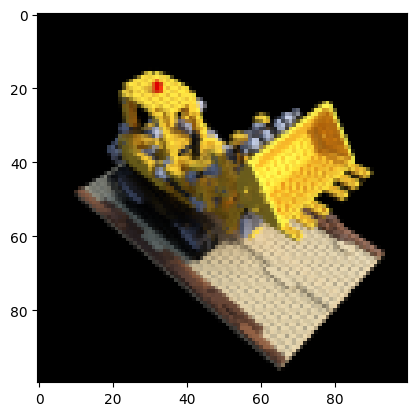

In [ ]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

(The cool part!)

In [ ]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # "Flatten" the query points.
  flattened_query_points = query_points.reshape((-1, 3))

  # Encode the query points (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(encoded_points, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 0.13805823028087616


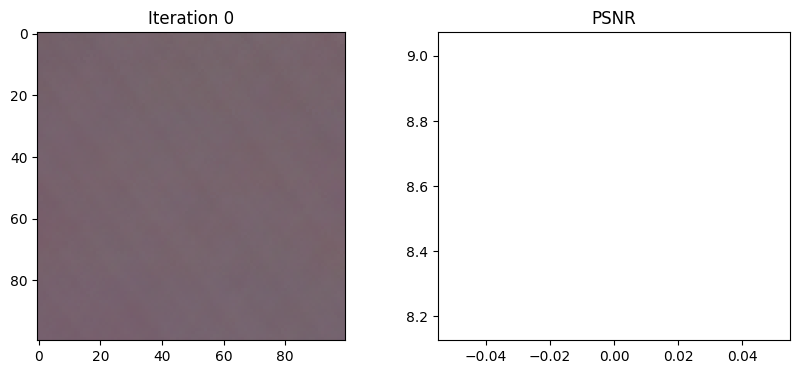

Loss: 0.025136983022093773


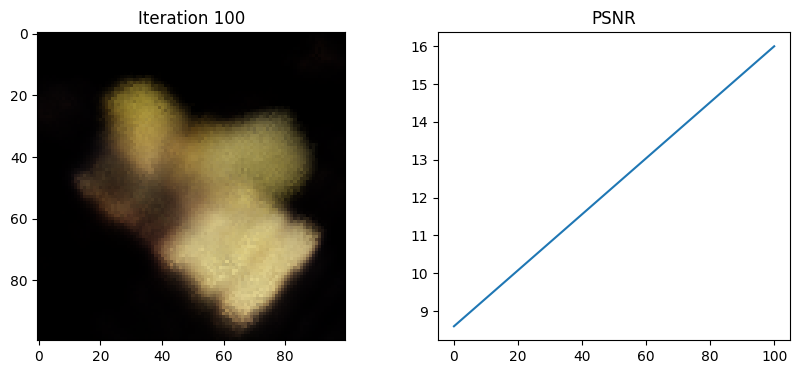

Loss: 0.1018633171916008


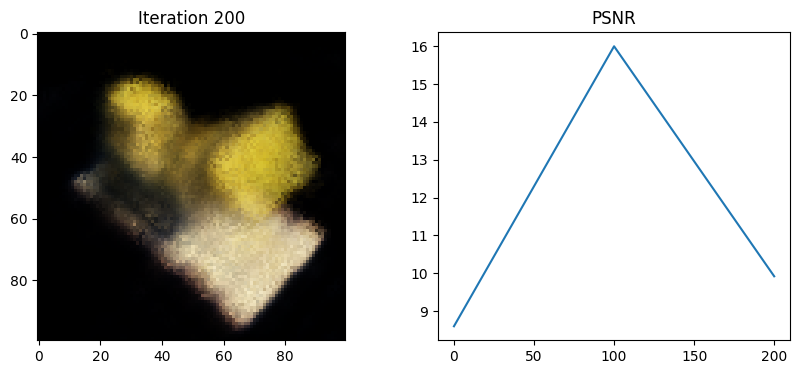

Loss: 0.0974348783493042


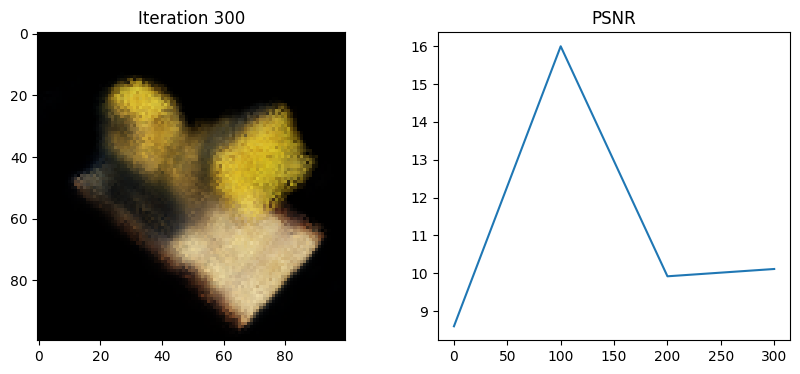

Loss: 0.07463353872299194


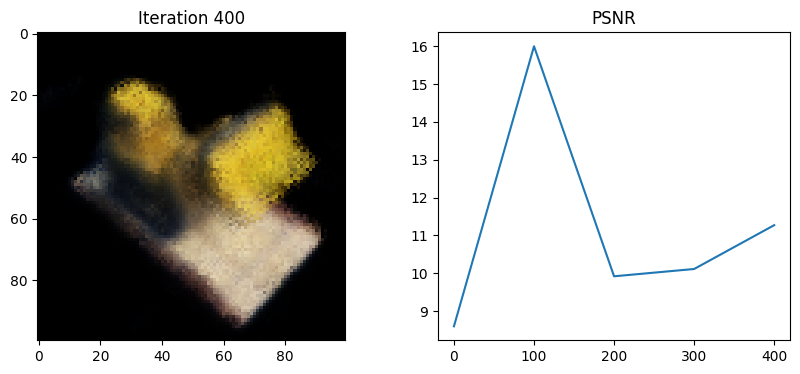

Loss: 0.05073758587241173


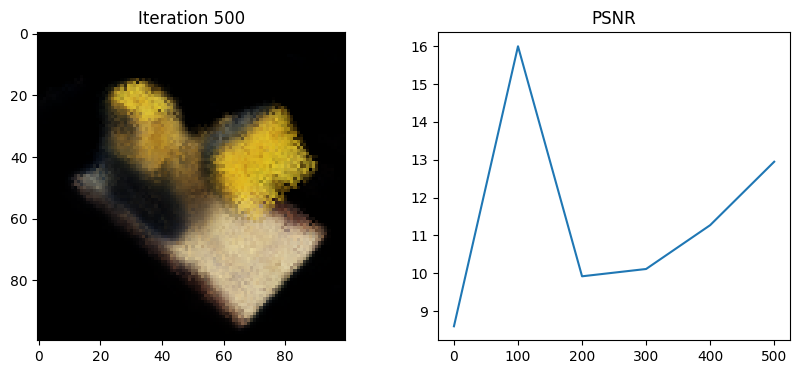

Loss: 0.10146447271108627


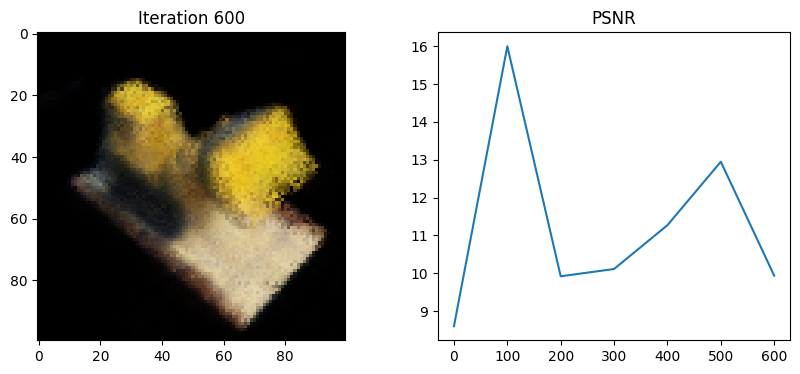

Loss: 0.09684234857559204


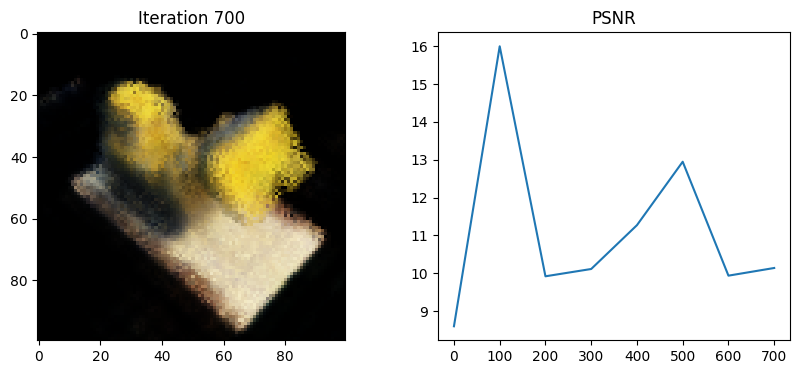

Loss: 0.09400641173124313


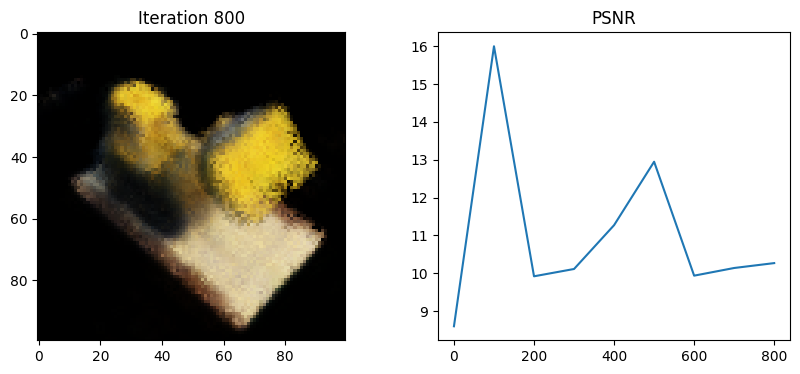

Loss: 0.06939343363046646


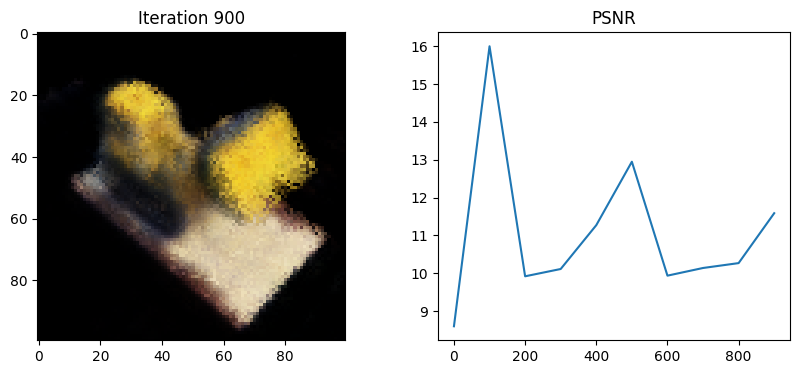

Done!


In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-3
num_iters = 1000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = VeryTinyNerfModel(num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')